## Neural Networks from scratch

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import struct

## Data loaders

In [39]:
def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows * cols)
    return images

def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

In [40]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z) * (1 - sigmoid(z))

def relu(z):
    return np.maximum(0, z)

def relu_prime(z):
    return (z > 0).astype(float)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

def one_hot(Y, num_classes):
    one_hot_Y = np.zeros((num_classes, Y.size))
    one_hot_Y[Y, np.arange(Y.size)] = 1
    return one_hot_Y

# ... Add more activation functions here if required


In [41]:
class NeuralNetwork:
    def __init__(self, layers):
        self.n_layers = len(layers)
        self.weights = []
        self.biases = []

        # Initialize weights with Xavier/Glorot initialization
        for i in range(1, self.n_layers):
            self.weights.append(np.random.randn(layers[i], layers[i - 1]) * np.sqrt(1 / layers[i - 1]))
            self.biases.append(np.zeros((layers[i], 1)))

    def forward_propagation(self, X):
        activations = [X]
        zs = []

        # Hidden layers use relu as the activation function
        for i in range(len(self.weights) - 1):
            z = np.dot(self.weights[i], activations[-1]) + self.biases[i]
            zs.append(z)
            activations.append(relu(z))

        # Output layer uses softmax for it's activation function
        z = np.dot(self.weights[-1], activations[-1]) + self.biases[-1]
        zs.append(z)
        activations.append(softmax(z))

        return activations, zs

    def backward_propagation(self, X, Y):
        activations, zs = self.forward_propagation(X)
        Y = one_hot(Y, activations[-1].shape[0])

        delta = activations[-1] - Y
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        nabla_b = [np.zeros(b.shape) for b in self.biases]

        # Output layer gradient
        nabla_w[-1] = np.dot(delta, activations[-2].T) / X.shape[1]
        nabla_b[-1] = np.sum(delta, axis=1, keepdims=True) / X.shape[1]

        # Backpropagation through hidden layers
        for l in range(2, self.n_layers):
            delta = np.dot(self.weights[-l + 1].T, delta) * relu_prime(zs[-l])
            nabla_w[-l] = np.dot(delta, activations[-l - 1].T) / X.shape[1]
            nabla_b[-l] = np.sum(delta, axis=1, keepdims=True) / X.shape[1]

        return nabla_w, nabla_b

    def update_parameters(self, nabla_w, nabla_b, learning_rate):
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * nabla_w[i]
            self.biases[i] -= learning_rate * nabla_b[i]

    def compute_loss(self, Y, Y_hat):
        m = Y.shape[1]
        return -np.sum(Y * np.log(Y_hat + 1e-8)) / m
        
    def compute_accuracy(self, X, Y):
        predictions, _ = self.forward_propagation(X)
        predicted_labels = np.argmax(predictions[-1], axis=0)
        return np.mean(predicted_labels == Y) * 100

    def train(self, X, Y, epochs, learning_rate=0.1):
        losses = []
        accuracies = []
        for epoch in range(epochs):
            nabla_w, nabla_b = self.backward_propagation(X, Y)
            self.update_parameters(nabla_w, nabla_b, learning_rate)

            if epoch % 1 == 0:
                loss = self.compute_loss(one_hot(Y, 10), self.forward_propagation(X)[0][-1])
                losses.append(loss)
                accuracy = self.compute_accuracy(X, Y)
                accuracies.append(accuracy)
                print(f"Epoch {epoch}, Loss: {loss:.5f}, Accuracy: {accuracy:.2f}%")

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Loss curve
        axes[0].plot(range(epochs), losses, label="Loss")
        axes[0].set_xlabel("Epochs")
        axes[0].set_ylabel("Loss")
        axes[0].set_title("Training Loss Curve")
        axes[0].legend()

        # Accuracy curve
        axes[1].plot(range(epochs), accuracies, color="orange", label="Accuracy")
        axes[1].set_xlabel("Epochs")
        axes[1].set_ylabel("Accuracy (%)")
        axes[1].set_title("Training Accuracy Curve")
        axes[1].legend()

        plt.show()

    def test(self, X_test, Y_test):
        accuracy = self.compute_accuracy(X_test, Y_test)
        print(f"Test Accuracy: {accuracy:.2f}%")

    def predict(self, X):
        # Ensure that the input is a column vector
        if X.shape == (28, 28):
            X = X.reshape(784, 1)
        elif X.shape == (784,):
            X = X.reshape(784, 1)
        activations, _ = self.forward_propagation(X)

        probabilities = activations[-1]
        prediction = np.argmax(probabilities, axis=0)[0]

        plt.imshow(X.reshape(28, 28), cmap='gray')
        plt.title(f"Predicted Label: {prediction}")
        plt.axis('off')
        plt.show()


In [42]:
X_train = load_mnist_images('archive/train-images-idx3-ubyte/train-images-idx3-ubyte')
Y_train = load_mnist_labels('archive/train-labels-idx1-ubyte/train-labels-idx1-ubyte')
X_test = load_mnist_images('archive/t10k-images.idx3-ubyte')
Y_test = load_mnist_labels('archive/t10k-labels.idx1-ubyte')

# Normalize pixel values to [0,1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

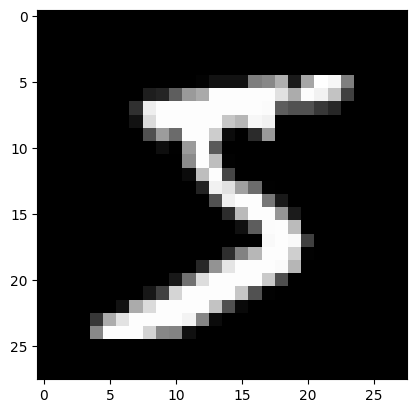

In [43]:
plt.gray()
plt.imshow(X_train[0].reshape(28, 28), interpolation='nearest')
plt.show()

In [44]:
# Reshape from (num_samples, 784) to (784, num_samples) for matrix multiplication
X_train = X_train.T
X_test = X_test.T

Training details:
Epoch 0, Loss: 2.26790, Accuracy: 14.01%
Epoch 1, Loss: 2.22531, Accuracy: 19.63%
Epoch 2, Loss: 2.18722, Accuracy: 25.75%
Epoch 3, Loss: 2.15128, Accuracy: 29.62%
Epoch 4, Loss: 2.11677, Accuracy: 32.43%
Epoch 5, Loss: 2.08332, Accuracy: 34.51%
Epoch 6, Loss: 2.05067, Accuracy: 36.22%
Epoch 7, Loss: 2.01884, Accuracy: 37.74%
Epoch 8, Loss: 1.98791, Accuracy: 38.97%
Epoch 9, Loss: 1.95793, Accuracy: 40.07%
Epoch 10, Loss: 1.92889, Accuracy: 40.98%
Epoch 11, Loss: 1.90072, Accuracy: 41.72%
Epoch 12, Loss: 1.87333, Accuracy: 42.51%
Epoch 13, Loss: 1.84665, Accuracy: 43.30%
Epoch 14, Loss: 1.82061, Accuracy: 44.11%
Epoch 15, Loss: 1.79515, Accuracy: 44.90%
Epoch 16, Loss: 1.77026, Accuracy: 45.72%
Epoch 17, Loss: 1.74588, Accuracy: 46.67%
Epoch 18, Loss: 1.72196, Accuracy: 47.63%
Epoch 19, Loss: 1.69848, Accuracy: 48.68%
Epoch 20, Loss: 1.67538, Accuracy: 49.66%
Epoch 21, Loss: 1.65265, Accuracy: 50.65%
Epoch 22, Loss: 1.63027, Accuracy: 51.63%
Epoch 23, Loss: 1.60821, A

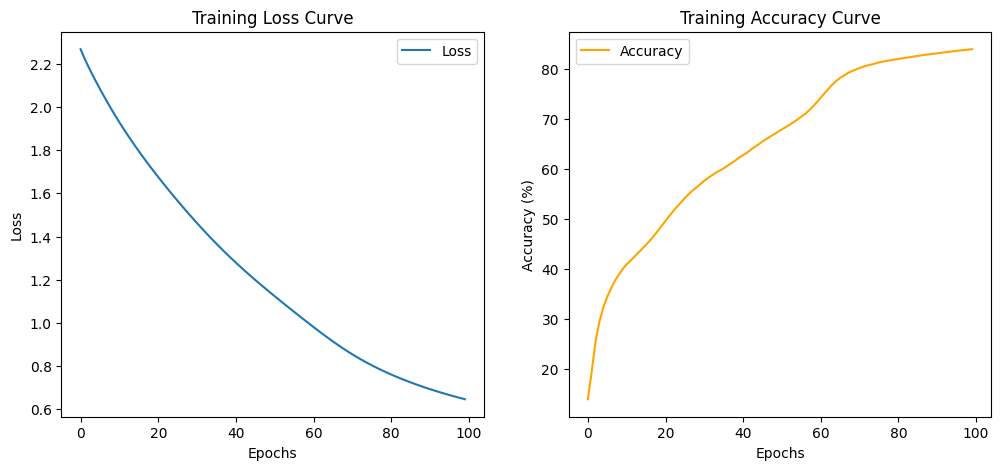

Testing details
Test Accuracy: 84.68%


In [45]:
nn = NeuralNetwork([784, 10, 10])

print("Training details:")
nn.train(X_train, Y_train, 100)

print("Testing details")
nn.test(X_test, Y_test)

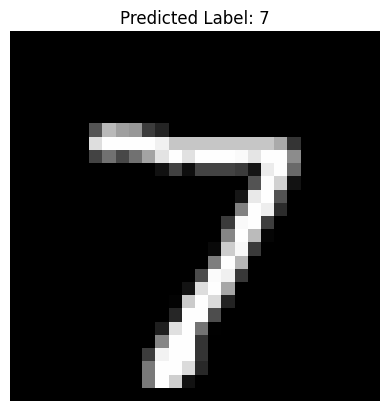

In [46]:
sample_image = X_test.T[0]
nn.predict(sample_image)